**IMPORT LIBRARIES**

In [1]:
import numpy as np
from numpy.random import randn, randint
import pandas as pd
from time import time 
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Activation, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping

from keras.datasets.mnist import load_data

import warnings
warnings.filterwarnings("ignore")

**LOAD DATA**

In [2]:
(X_train, Y_train), (X_test, Y_test) = load_data()
X_train = X_train/255.0
X_test = X_test/255.0 
X_train = X_train.reshape([60000,28,28,1])
X_test = X_test.reshape([10000,28,28,1])

11493376/11490434 [==============================] - 0s 0us/step


**BUILD MODEL**

In [3]:
# generator architecture

def generator(vec_size):
  model = Sequential()

  # takes vector input
  model.add(Dense(7*7*128, input_dim=vec_size))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # gives image output
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

In [4]:
# discriminator architecture

def discriminator():
  model = Sequential()

  # takes image input
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())

  # gives digit output
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [5]:
# GAN architecture

def GAN(discriminator, generator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

**UTILITY FUNCTIONS**

In [6]:
# sample real data

def gen_real(num):
  index = randint(0, X_train.shape[0], num)
  realX = X_train[index]
  realY = np.ones((num,1))
  return realX, realY

# generate fake data

def gen_fake(generator,dim,num):
  fakeX = randn(dim * num)
  fakeX = fakeX.reshape(num,dim)
  fakeX = generator.predict(fakeX)
  fakeY = np.zeros((num,1))
  return fakeX, fakeY  

# **TASK 1**

In [33]:
# train GAN

vec_size = 100
gen = generator(vec_size)
dis = discriminator()
gan = GAN(dis, gen)

gen_hist = []
dis_hist = []

epochs = 50
batchSize = 300
totalSteps = X_train.shape[0]//batchSize

for i in range(epochs):
  
  g_loss_total = 0
  d_loss_total = 0

  if (i==0 or i==(epochs//2) or i==(epochs-1)):
    fakeX, fakeY = gen_fake(gen,vec_size,30)
    
    fig = plt.figure(figsize=(18,8))
    for ind in range(30):
      plt.subplot(3, 10, ind + 1)
      plt.axis('off')
      plt.imshow(fakeX[ind, :, :, 0], cmap='gray')
    filename = 'epoch_' + str(i) + '.png'
    plt.savefig(filename)
    plt.close(fig)

  for j in range(totalSteps):
    realX, realY = gen_real(batchSize//2)
    fakeX, fakeY = gen_fake(gen,vec_size,batchSize//2)
    finalX, finalY = np.vstack((realX, fakeX)), np.vstack((realY, fakeY))
    dis.trainable = True
    d_loss, _ = dis.train_on_batch(finalX, finalY)
    d_loss_total += d_loss
    
    genX = randn(vec_size * batchSize)
    genX = genX.reshape(batchSize, vec_size)
    genY = np.ones((batchSize,1))
    g_loss = gan.train_on_batch(genX, genY)
    
    g_loss_total += g_loss

  print('Epoch: {}/{}  ..... g_loss: {} ..... d_loss: {}'.format(i+1,epochs,round(g_loss_total/totalSteps,8),(d_loss_total/totalSteps)))
  
  dis_hist.append(d_loss_total/totalSteps)
  gen_hist.append(g_loss_total/totalSteps)

gen.save_weights('g.h5')

Epoch: 1/50  ..... g_loss: 0.99964594 ..... d_loss: 0.43815477795898916
Epoch: 2/50  ..... g_loss: 0.77298076 ..... d_loss: 0.7018202300369739
Epoch: 3/50  ..... g_loss: 0.71635734 ..... d_loss: 0.6924741181731224
Epoch: 4/50  ..... g_loss: 0.70934532 ..... d_loss: 0.6928958955407143
Epoch: 5/50  ..... g_loss: 0.72155329 ..... d_loss: 0.6930709946155548
Epoch: 6/50  ..... g_loss: 0.71389397 ..... d_loss: 0.6880275249481201
Epoch: 7/50  ..... g_loss: 0.71375395 ..... d_loss: 0.6875674131512642
Epoch: 8/50  ..... g_loss: 0.70763568 ..... d_loss: 0.691138199865818
Epoch: 9/50  ..... g_loss: 0.71239245 ..... d_loss: 0.6900110846757889
Epoch: 10/50  ..... g_loss: 0.70435045 ..... d_loss: 0.6902990666031837
Epoch: 11/50  ..... g_loss: 0.70413191 ..... d_loss: 0.6888960829377174
Epoch: 12/50  ..... g_loss: 0.70466869 ..... d_loss: 0.6896461001038552
Epoch: 13/50  ..... g_loss: 0.70663347 ..... d_loss: 0.6858359509706498
Epoch: 14/50  ..... g_loss: 0.70722263 ..... d_loss: 0.6848693171143532
E

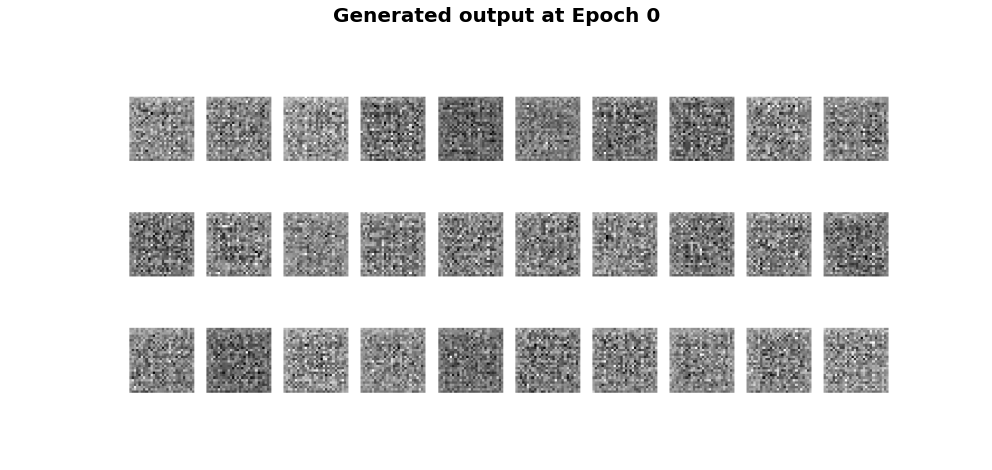

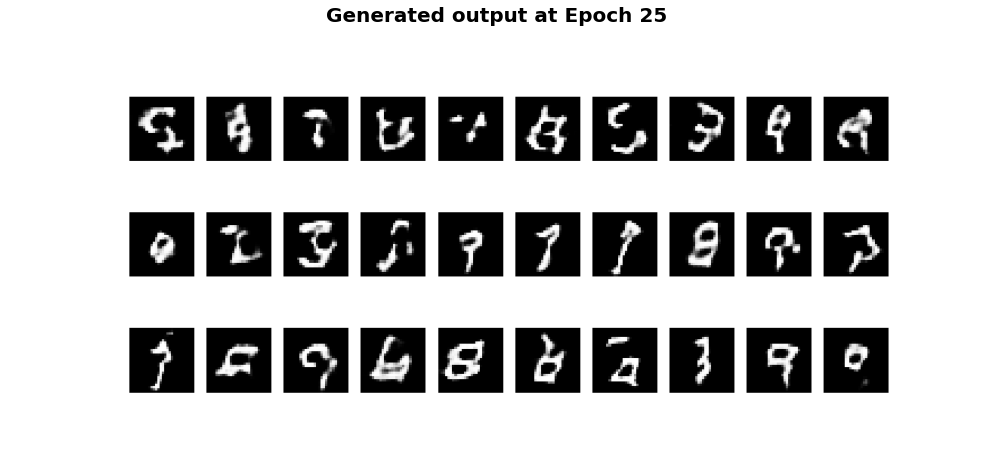

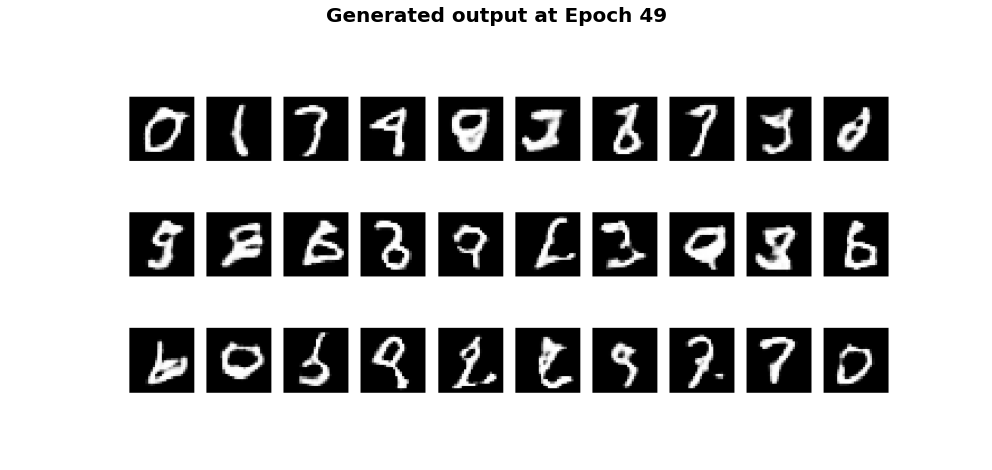

In [34]:
# visualize results at different points in training

epoch = [0, epochs//2, epochs-1]
for i in range(3):
  plt.figure(figsize=(18,8))
  filename = '/content/epoch_' + str(epoch[i]) + '.png'
  img = plt.imread(filename)
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title('Generated output at Epoch '+str(epoch[i]), fontsize=20, fontweight = 'bold')
  plt.show()

**Observations**
* The images generated by Generator at start of training are completely noisy and random, no digits can be seen.
* Midway of training process, Generator gradually starts to learn and generates images that have started taking form of digits, although not very completely. 
* When the training ends, Generator is trained enough to produce images that look close to actual digits.

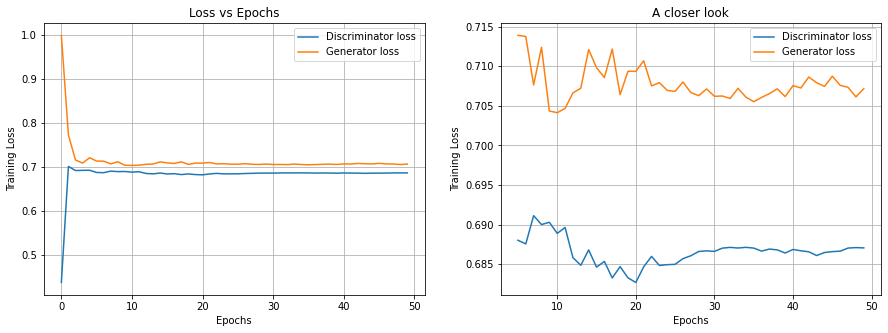

In [60]:
# visualize variation in losses

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(dis_hist[:])
plt.plot(gen_hist[:])
plt.legend(['Discriminator loss','Generator loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.arange(5,50,1,dtype=int),dis_hist[5:])
plt.plot(np.arange(5,50,1,dtype=int),gen_hist[5:])
plt.legend(['Discriminator loss','Generator loss'])
plt.title('A closer look')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid()

plt.show()

**Observations**
* Generator and Discriminator compete with each other while one tries to do better than the other one, so their losses go in opposite direction.  
* When G loss increses, D loss decreaes and vice versa as we can see from the closer look image.
* Finally, towards the end both the losses converge to soem value and no further competition i.e. training is possible. 
* Thus, GAN must be trained as whole only and not Generator and Discriinator trained separately.

# **TASK 2**

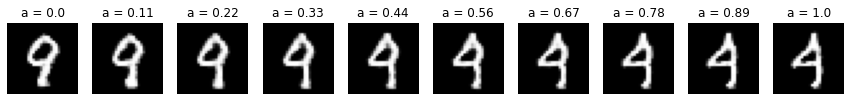

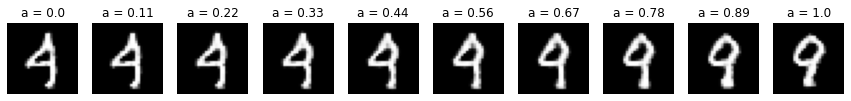

In [59]:
genX1 = randn(100 * 1)
genX1 = genX1.reshape(1, 100)

genX2 = randn(100 * 1)
genX2 = genX2.reshape(1, 100)

alpha = np.reshape(np.linspace(0,1,10),(10,1))
interpolation = alpha*genX1 + (1-alpha)*genX2
interpolation2 = alpha*genX2 + (1-alpha)*genX1

results = gen.predict(interpolation)
results2 = gen.predict(interpolation2)

plt.figure(figsize = (15,30))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(np.reshape(results[i],(28,28)),cmap='gray')
  plt.axis('off')
  plt.title(r'a = {}'.format(round(alpha[i][0],2)))

plt.figure(figsize = (15,30))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(np.reshape(results2[i],(28,28)),cmap='gray')
  plt.axis('off')
  plt.title(r'a = {}'.format(round(alpha[i][0],2)))

**Observations**
* When alpha (a) = 0, the generated results completely represent one digit (i.e. one class)
* When alpha (a) = 1, the generated results completely represent another digit (i.e. another class)
* There will be some corresponding latent space represnetaion learnt by the generator for both these classes. The results above shows that the generator has the ability of interpolate within the latent spaces and generate images that show the transition from one class to another.
* These results show the intermediate images generated by Generator from the latent space representation while going from digit 9 to digit 4 and back to digit 9 from digit 4.

# **TASK 3**

**AUGMENT DATASET AND ADD NOISE**

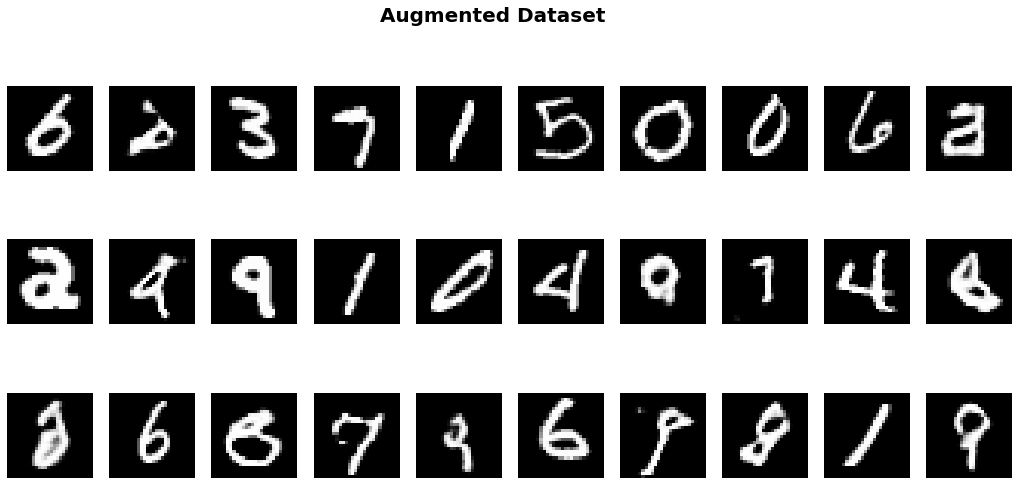

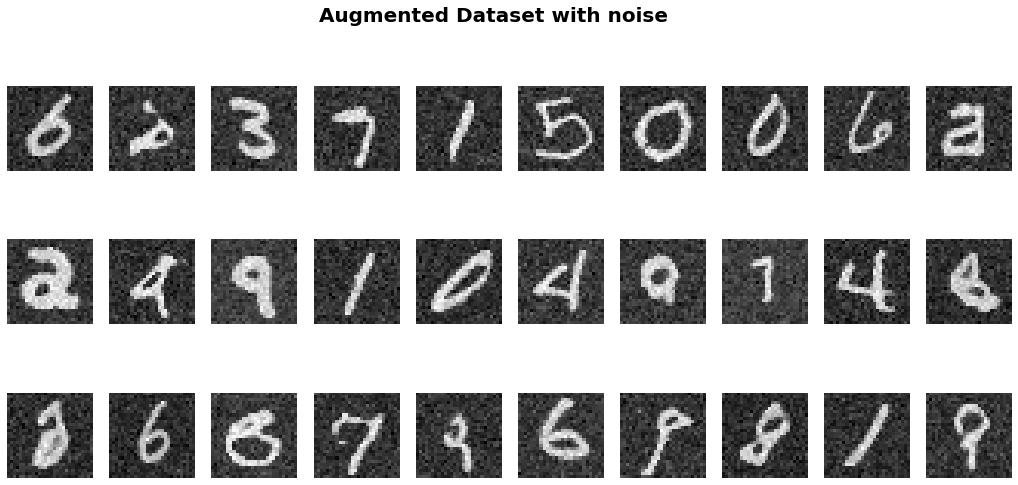

In [72]:
fakeX, fakeY = gen_fake(gen, 100, 60000)

# augment original data with generated images
X_train_add = np.vstack((X_train,fakeX))

# shuffle the augmented data and sample 60000 out of it
ind = np.array(np.arange(X_train_add.shape[0]))
np.random.shuffle(ind)
X_train_add = X_train_add[ind,:,:,:]
X_train_add = X_train_add[:60000]

# add noise to original and augmented data
X_train_noise = X_train + 50*np.random.normal(0,1,size=X_train.shape)/255.0
X_train_add_noise = X_train_add + 25*np.random.normal(0,1,size=X_train_add.shape)/255.0 
X_test_noise = X_test + 25*np.random.normal(0,1,size=X_test.shape)/255.0

plt.figure(figsize=(18,8))
for ind in range(30):
  plt.subplot(3, 10, ind + 1)
  plt.axis('off')
  plt.imshow(X_train_add[ind, :, :, 0], cmap='gray')
plt.suptitle('Augmented Dataset', fontsize=20, fontweight = 'bold')
plt.show()

plt.figure(figsize=(18,8))
for ind in range(30):
  plt.subplot(3, 10, ind + 1)
  plt.axis('off')
  plt.imshow(X_train_add_noise[ind, :, :, 0], cmap='gray')
plt.suptitle('Augmented Dataset with noise', fontsize=20, fontweight = 'bold')
plt.show()

**DENOISING MODEL**

In [73]:
def denoise():
  model = Sequential()
  model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(6272,activation='relu'))
  model.add(Reshape((14,14,32)))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))
  model.compile('adam',loss='mse',metrics=['mse'])
  return model

**RUN ON ORIGINAL DATASET**

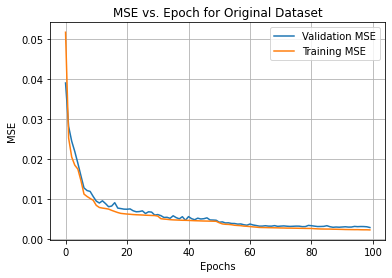

In [104]:
ori = denoise()
history_ori = ori.fit(X_train_noise, X_train, epochs=100, batch_size=550, validation_data=(X_test_noise,X_test), verbose=0)

plt.figure()
plt.plot(history_ori.history['val_mse'])
plt.plot(history_ori.history['mse'])
plt.legend(['Validation MSE','Training MSE'])
plt.title('MSE vs. Epoch for Original Dataset')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

**Observation**
* The model trains well on the original dataset as expected. Validation MSE follows the trend of training MSE, so there is neither underfitting nor overfitting.

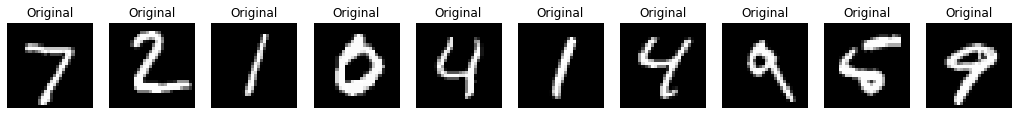

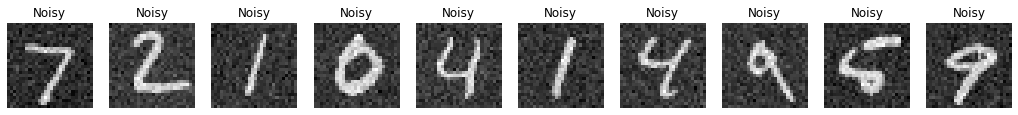

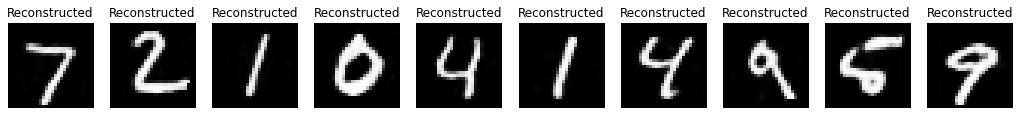

In [105]:
ori_rec = ori.predict(X_test_noise)

n = 10

plt.figure(figsize=(18, 8))
for i in range(n):
  plt.subplot(1, n, i + 1)
  plt.imshow(X_test[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Original')

plt.figure(figsize=(18, 8))
for i in range(n):
  plt.subplot(3, n, i+1+n)
  plt.imshow(X_test_noise[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Noisy')

plt.figure(figsize=(18, 8))
for i in range(n):
  plt.subplot(3, n, i+1+2*n)
  plt.imshow(ori_rec[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Reconstructed')

plt.show()

**Observations**
* Reconstructed images are very close to original images from the original dataset. There is no significant visual perception of noise for denoising is done perfectly as expected. 

**RUN ON AUGMENTED DATASET**

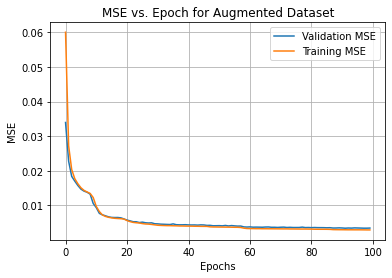

In [ ]:
aug = denoise()
history_aug = aug.fit(X_train_add_noise, X_train_add, epochs=100, batch_size=550, validation_data=(X_test_noise,X_test), verbose=0)

plt.figure()
plt.plot(history_aug.history['val_mse'])
plt.plot(history_aug.history['mse'])
plt.legend(['Validation MSE','Training MSE'])
plt.title('MSE vs. Epoch for Augmented Dataset')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.show()

**Observation**
* The model seems to train perfectly even on the augmented dataset. Validation MSE follows the trend of training MSE, so there is neither underfitting nor overfitting even while using generated images for training.

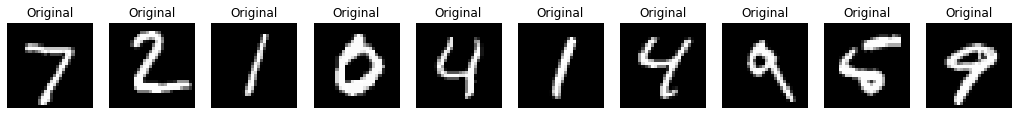

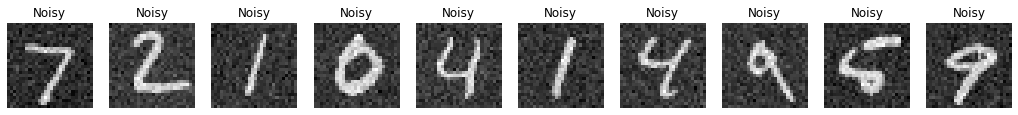

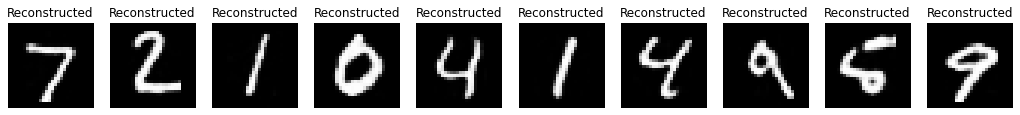

In [ ]:
aug_rec = aug.predict(X_test_noise)

n = 10

plt.figure(figsize=(18, 8))
for i in range(n):
  plt.subplot(1, n, i + 1)
  plt.imshow(X_test[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Original')

plt.figure(figsize=(18, 8))
for i in range(n):
  plt.subplot(3, n, i+1+n)
  plt.imshow(X_test_noise[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Noisy')

plt.figure(figsize=(18, 8))
for i in range(n):
  plt.subplot(3, n, i+1+2*n)
  plt.imshow(aug_rec[i,:,:,0],cmap='gray')
  plt.axis('off')
  plt.title('Reconstructed')

plt.show()

**Observations**
* Reconstructed images are very close to original images from the augmented dataset. There is no significant visual perception of noise for denoising is done perfectly here as well. 

**COMPARISON**

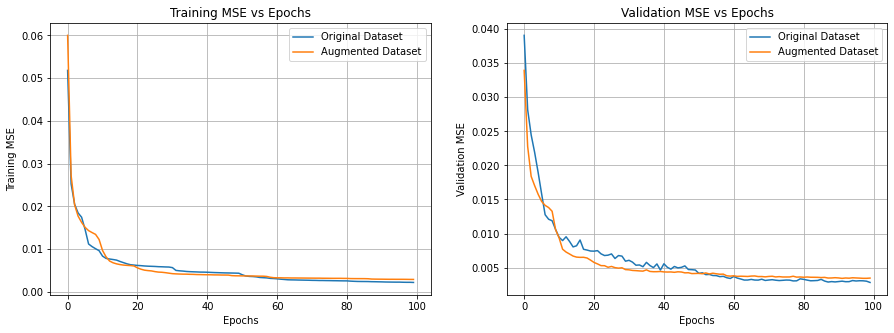

In [107]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history_ori.history['mse'])
plt.plot(history_aug.history['mse'])
plt.legend(['Original Dataset','Augmented Dataset'])
plt.title('Training MSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
plt.grid()

plt.subplot(1,2,2)
plt.plot(history_ori.history['val_mse'])
plt.plot(history_aug.history['val_mse'])
plt.legend(['Original Dataset','Augmented Dataset'])
plt.title('Validation MSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.grid()
plt.show()

**Observations**
* The training MSE and validation MSE for models trained on both original and augmented dataset follow almost the same trend and converge to similar values.
* This strongly suggests that GANs can be used to augment insufficient training datasets with very reliable generated synthetic data with any major difference in performance/results.